In [1]:
import numpy as np
import numpy.random

# Моделирование данных датчика
def simulateSensor(samplesCount, noiseSigma, dt):
   # Шум с нормальным распределением. мат. ожидание = 0, среднеквадратичное отклонение = noiseSigma
   noise = numpy.random.normal(loc = 0.0, scale = noiseSigma, size = samplesCount)

   trajectory = np.zeros((3, samplesCount))

   position = 0
   velocity = 1.0
   acceleration = 0.0

   for i in range(1, samplesCount):
       position = position + velocity * dt + (acceleration * dt ** 2) / 2.0
       velocity = velocity + acceleration * dt
       acceleration = acceleration

       trajectory[0][i] = position
       trajectory[1][i] = velocity
       trajectory[2][i] = acceleration

   measurement = trajectory[0] + noise

   return trajectory, measurement # Истинное значение и данные "датчика" с шумом

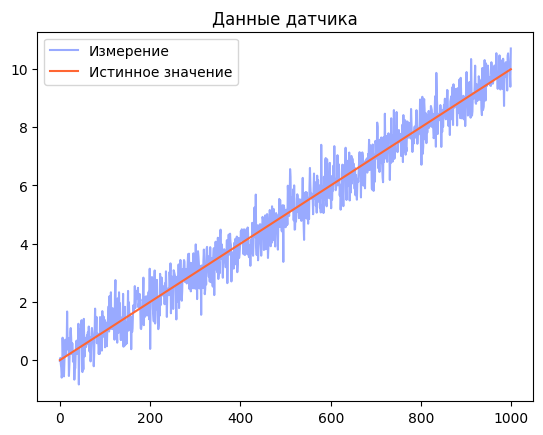

In [2]:
import matplotlib.pyplot as plt
dt = 0.01
measurementSigma = 0.5
trajectory, measurement = simulateSensor(1000, measurementSigma, dt)

plt.title("Данные датчика")
plt.plot(measurement, label="Измерение", color="#99AAFF")
plt.plot(trajectory[0], label="Истинное значение", color="#FF6633")
plt.legend()
plt.show()

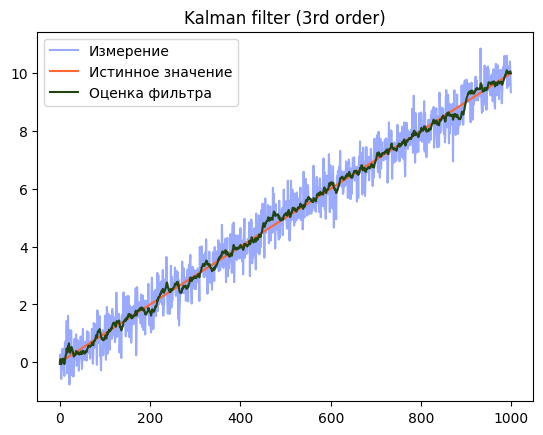

In [3]:
import filterpy.kalman
import filterpy.common
import matplotlib.pyplot as plt
import numpy as np
import numpy.random
#from Simulator import simulateSensor # моделирование датчиков

dt = 0.01                       # Шаг времени
measurementSigma = 0.5          # Среднеквадратичное отклонение датчика
processNoise = 1e-4             # Погрешность модели

# Моделирование данных датчиков
trajectory, measurement = simulateSensor(1000, measurementSigma, dt)

# Создаём объект KalmanFilter
filter = filterpy.kalman.KalmanFilter(dim_x=3,      # Размер вектора стостояния
                                     dim_z=1)      # Размер вектора измерений

# F - матрица процесса - размер dim_x на dim_x - 3х3
filter.F = np.array([ [1,   dt,     (dt**2)/2],
                     [0,   1.0,    dt],
                     [0,   0,      1.0]])


# Матрица наблюдения - dim_z на dim_x - 1x3
filter.H = np.array([[1.0, 0.0, 0.0]])

# Ковариационная матрица ошибки модели
filter.Q = filterpy.common.Q_discrete_white_noise(dim=3, dt=dt, var=1.0) #var - дисперсия (спетральная плотность белого шума)

# Ковариационная матрица ошибки измерения - 1х1
filter.R = np.array([[measurementSigma*measurementSigma]])

# Начальное состояние.
filter.x = np.array([0.0, 0.0, 0.0])

# Ковариационная матрица для начального состояния
filter.P = np.array([[10.0, 0.0,  0.0],
                    [0.0,  10.0, 0.0],
                    [0.0,  0.0,  10.0]])

filteredState = []
stateCovarianceHistory = []

# Обработка данных
for i in range(0, len(measurement)):
   z = [ measurement[i] ]                      # Вектор измерений
   filter.predict()                            # Этап предсказания
   filter.update(z)                            # Этап коррекции

   filteredState.append(filter.x)
   stateCovarianceHistory.append(filter.P)

filteredState = np.array(filteredState)
stateCovarianceHistory = np.array(stateCovarianceHistory)

# Визуализация
plt.title("Kalman filter (3rd order)")
plt.plot(measurement, label="Измерение", color="#99AAFF")
plt.plot(trajectory[0], label="Истинное значение", color="#FF6633")
plt.plot(filteredState[:, 0], label="Оценка фильтра", color="#224411")
plt.legend()
plt.show()

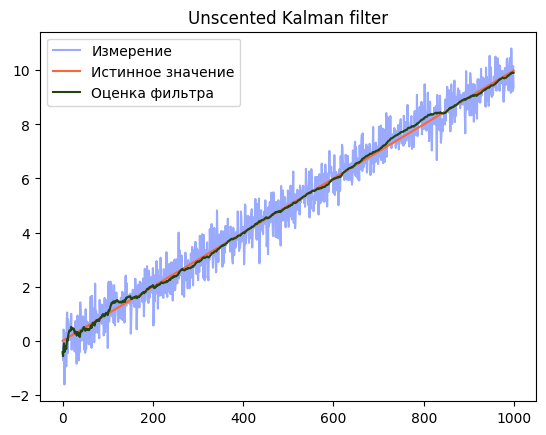

In [4]:
import filterpy.kalman
import filterpy.common
import matplotlib.pyplot as plt
import numpy as np
import numpy.random
#from Simulator import simulateSensor, CovarianceQ

dt = 0.01
measurementSigma = 0.5
processNoiseVariance = 1e-4

# Функция наблюдения - аналог матрицы наблюдения
# Преобразует вектор состояния x в вектор измерений z
def measurementFunction(x):
   return np.array([x[0]])

# Функция процесса - аналог матрицы процесса
def stateTransitionFunction(x, dt):
   newState = np.zeros(3)
   newState[0] = x[0] + dt * x[1] + ( (dt**2)/2 ) * x[2]
   newState[1] = x[1] + dt * x[2]
   newState[2] = x[2]

   return newState


trajectory, measurement = simulateSensor(1000, measurementSigma, dt)

# Для unscented kalman filter необходимо выбрать алгоритм выбора сигма-точек
points = filterpy.kalman.JulierSigmaPoints(3, kappa=0)

# Создаём объект UnscentedKalmanFilter
filter = filterpy.kalman.UnscentedKalmanFilter(dim_x = 3,
                                              dim_z = 1,
                                              dt = dt,
                                              hx = measurementFunction,
                                              fx = stateTransitionFunction,
                                              points = points)



# Ковариационная матрица ошибки модели
filter.Q = filterpy.common.Q_discrete_white_noise(dim=3, dt=dt, var=processNoiseVariance)

# Ковариационная матрица ошибки измерения - 1х1
filter.R = np.array([[measurementSigma*measurementSigma]])

# Начальное состояние.
filter.x = np.array([0.0, 0.0, 0.0])

# Ковариационная матрица для начального состояния
filter.P = np.array([[10.0, 0.0,  0.0],
                    [0.0,  10.0, 0.0],
                    [0.0,  0.0,  10.0]])

filteredState = []
stateCovarianceHistory = []

for i in range(0, len(measurement)):
   z = [ measurement[i] ]
   filter.predict()
   filter.update(z)

   filteredState.append(filter.x)
   stateCovarianceHistory.append(filter.P)

filteredState = np.array(filteredState)
stateCovarianceHistory = np.array(stateCovarianceHistory)

plt.title("Unscented Kalman filter")
plt.plot(measurement, label="Измерение", color="#99AAFF")
plt.plot(trajectory[0], label="Истинное значение", color="#FF6633")
plt.plot(filteredState[:, 0], label="Оценка фильтра", color="#224411")
plt.legend()
plt.show()
